 <p style = "font-size: 35px;font-weight: bold;text-align:center;color:#800000"> Ecosure Violations & Review Sentiment All Brands Analysis </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 05/11/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures. We are comparing audits data with sentiment scores and rating.<br>

Data Used: <br>
* For <b>Audit Information</b>, across different brands, we have used <b>Ecosure BI Data</b> stored in <b>SQLServer</b>
* For <b>Sentiment Information</b>, across different brands, we have used different review sample pulled from <b>DataFinity API</b>

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import os
import warnings
import itertools
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.stats.stats import pearsonr
from scipy import stats
import matplotlib
import seaborn as sns
import pytz
import pyodbc
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
######################################################### Audit Data ###################################################################
########################################################################################################################################

df_audit = pd.read_csv('./csv/EcosureAudits80.csv')

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit['Date'] = df_audit['AuditStarted'].dt.date
df_audit['month_year'] = df_audit['Date'].apply(lambda x: x.strftime('%B-%Y'))

df_violations = df_audit.groupby(['month_year'], as_index=False).agg({'Level1_Violations' : 'sum', 'Level2_Violations' : 'sum',
                                                                      'Level3_Violations' : 'sum', 'Score' : 'mean', 
                                                                      'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'Level1_Violations' : 'Minor_Violations', 
                      'Level2_Violations' : 'Major_Violations',
                      'Level3_Violations' : 'Critical_Violations',
                      'Score' : 'Mean_Audit_Score',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

# Adding KPIs
df_violations['Total_No_of_Violations'] = df_violations['Minor_Violations'] + df_violations['Major_Violations'] + df_violations['Critical_Violations']

# Adding Normalized KPIs
df_violations['Minor_Violations_per_audit'] = df_violations['Minor_Violations']/df_violations['No_of_Audits']
df_violations['Major_Violations_per_audit'] = df_violations['Major_Violations']/df_violations['No_of_Audits']
df_violations['Critical_Violations_per_audit'] = df_violations['Critical_Violations']/df_violations['No_of_Audits']
df_violations['Total_No_of_Violations_per_audit'] = df_violations['Total_No_of_Violations']/df_violations['No_of_Audits']

# Ordering by month
new_orders = ['September-2016', 'October-2016',  'November-2016', 'December-2016', 'January-2017', 'February-2017', 'March-2017', 'April-2017',
              'May-2017', 'June-2017', 'July-2017', 'August-2017', 'September-2017', 'October-2017', 'November-2017', 'December-2017',
              'January-2018', 'February-2018','March-2018','April-2018', 'May-2018', 'June-2018', 'July-2018', 'August-2018', 'September-2018',
              'October-2018', 'November-2018', 'December-2018', 'January-2019', 'February-2019', 'March-2019', 'April-2019', 
              'May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020','January-2021', 'February-2021', 'March-2021', 'April-2021']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)
df_violations = df_violations[df_violations.month_year.notnull()]

In [4]:
print("Total No of unique brands used for analysis:", df_audit.ClientName.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", df_audit.ClientName.unique())

Total No of unique brands used for analysis: 20

 

Name's of the brands used for analysis: ['Panera' 'IHOP' 'Buffalo Wild Wings' 'Noodles & Co.'
 "Famous Dave's of America,  Inc." 'True Food Kitchen' 'Twin Peaks'
 'Benihana National Corp' 'On the Border' "Applebee's" 'Texas Roadhouse'
 "Friendly's" 'Margaritaville' 'Cafe Zupas' 'Ruby Tuesday Inc.' 'WingStop'
 'Four Corners Tavern Group' 'Modern Market' 'Wood Ranch'
 "O'Charley's, Inc."]


In [5]:
########################################################## Reviews Data #################################################################
#########################################################################################################################################

# Reading reviews data
df_panera  = pd.read_csv('./csv/Panera_Bread.csv')
df_panera = df_panera.loc[:, ~df_panera.columns.str.contains('^Unnamed')]
df_panera['Brand'] = 'Panera'

df_ihop  = pd.read_csv('./csv/Ihop.csv')
df_ihop = df_ihop.loc[:, ~df_ihop.columns.str.contains('^Unnamed')]
df_ihop['Brand'] = 'IHOP'

df_buffalow = pd.read_csv('./csv/Buffalow_Wild_Wings.csv')
df_buffalow = df_buffalow.loc[:, ~df_buffalow.columns.str.contains('^Unnamed')]
df_buffalow['Brand'] = 'Buffalo Wild Wings'

df_noodles = pd.read_csv('./csv/Noodles_Company.csv')
df_noodles = df_noodles.loc[:, ~df_noodles.columns.str.contains('^Unnamed')]
df_noodles['Brand'] = 'Noodles & Co.'

df_benihana = pd.read_csv('./csv/Benihana.csv')
df_benihana = df_benihana.loc[:, ~df_benihana.columns.str.contains('^Unnamed')]
df_benihana['Brand'] = 'Benihana National Corp'

df_ontheboard = pd.read_csv('./csv/On_the_Border.csv')
df_ontheboard = df_ontheboard.loc[:, ~df_ontheboard.columns.str.contains('^Unnamed')]
df_ontheboard['Brand'] = 'On the Border'

df_applebees = pd.read_csv('./csv/Applebees.csv')
df_applebees = df_applebees.loc[:, ~df_applebees.columns.str.contains('^Unnamed')]
df_applebees['Brand'] = "Applebee's"

df_friendlys = pd.read_csv('./csv/Friendlys.csv')
df_friendlys = df_friendlys.loc[:, ~df_friendlys.columns.str.contains('^Unnamed')]
df_friendlys['Brand'] = "Friendly's"

df_margaritaville = pd.read_csv('./csv/Margaritaville.csv')
df_margaritaville = df_margaritaville.loc[:, ~df_margaritaville.columns.str.contains('^Unnamed')]
df_margaritaville['Brand'] = 'Margaritaville'

df_rubytuesday = pd.read_csv('./csv/Ruby_Tuesday.csv')
df_rubytuesday = df_rubytuesday.loc[:, ~df_rubytuesday.columns.str.contains('^Unnamed')]
df_rubytuesday['Brand'] = 'Ruby Tuesday Inc.'

df_wingstop = pd.read_csv('./csv/Wing_Stop.csv')
df_wingstop = df_wingstop.loc[:, ~df_wingstop.columns.str.contains('^Unnamed')]
df_wingstop['Brand'] = 'Ruby Tuesday Inc.'

df_modmarket = pd.read_csv('./csv/Modern_Market.csv')
df_modmarket = df_modmarket.loc[:, ~df_modmarket.columns.str.contains('^Unnamed')]
df_modmarket['Brand'] = 'Modern Market'

df_truefood = pd.read_csv('./csv/True_Food.csv')
df_truefood = df_truefood.loc[:, ~df_truefood.columns.str.contains('^Unnamed')]
df_truefood['Brand'] = 'True Food Kitchen'

df_txroadhouse = pd.read_csv('./csv/Texas_Roadhouse.csv')
df_txroadhouse = df_txroadhouse.loc[:, ~df_txroadhouse.columns.str.contains('^Unnamed')]
df_txroadhouse['Brand'] = 'Texas Roadhouse'

df_famousdave = pd.read_csv('./csv/Famous_Dave.csv')
df_famousdave = df_famousdave.loc[:, ~df_famousdave.columns.str.contains('^Unnamed')]
df_famousdave['Brand'] = "Famous Dave's of America, Inc."

df_zupas = pd.read_csv('./csv/Cafe_Zupas.csv')
df_zupas = df_zupas.loc[:, ~df_zupas.columns.str.contains('^Unnamed')]
df_zupas['Brand'] = 'Cafe Zupas'

df_fourcorners = pd.read_csv('./csv/Four_Corners.csv')
df_fourcorners = df_fourcorners.loc[:, ~df_fourcorners.columns.str.contains('^Unnamed')]
df_fourcorners['Brand'] = 'Four Corners Tavern Group'

df_charleys = pd.read_csv('./csv/O_Charleys.csv')
df_charleys = df_charleys.loc[:, ~df_charleys.columns.str.contains('^Unnamed')]
df_charleys['Brand'] = "O'Charley's, Inc."

df_twinpeaks = pd.read_csv('./csv/Twin_Peaks.csv')
df_twinpeaks = df_twinpeaks.loc[:, ~df_twinpeaks.columns.str.contains('^Unnamed')]
df_twinpeaks['Brand'] = 'Twin Peaks'

df_woodranch = pd.read_csv('./csv/Wood_Ranch.csv')
df_woodranch = df_woodranch.loc[:, ~df_woodranch.columns.str.contains('^Unnamed')]
df_woodranch['Brand'] = 'Wood Ranch'

df_review = df_modmarket.append([df_ihop, df_buffalow, df_noodles, df_benihana, df_ontheboard, df_applebees, df_friendlys, 
                                 df_margaritaville, df_rubytuesday, df_wingstop, df_panera, df_truefood, df_txroadhouse, 
                                 df_famousdave, df_zupas, df_fourcorners, df_charleys, df_twinpeaks, df_woodranch])

df_review = df_review[df_review['date'].notnull()]

# Getting Month-Year from date
df_review['Date'] = pd.to_datetime(df_review['date'], errors='coerce')
df_review['Date'] = df_review['Date'].dt.date
df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

# Flags to be used in aggregation
df_review['Negative_flag'] = np.where(df_review['Flair_Score'] < 0,1,0)
df_review['Positive_flag'] = np.where(df_review['Flair_Score'] > 0,1,0)

df_grouped_review = df_review.groupby(['month_year'], as_index=False).agg({'Flair_Score' : 'mean',
                                                                           'Positive_flag' : 'sum',
                                                                           'Negative_flag' : 'sum',
                                                                           'rating' : 'mean',
                                                                           'text' : 'count'})
df_grouped_review.rename({'text' : 'No_of_Reviews',
                          'rating' : 'Rating',
                          'Positive_flag': 'Positive_Reviews',
                          'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review['Positive_Review_Percent'] = (df_grouped_review['Positive_Reviews']/df_grouped_review['No_of_Reviews'])*100
df_grouped_review['Negative_Review_Percent'] = (df_grouped_review['Negative_Reviews']/df_grouped_review['No_of_Reviews'])*100

In [6]:
############################################# Merging Both the Datasets #################################################################
#########################################################################################################################################

df_merged = pd.merge(df_violations, df_grouped_review, how='left', on=['month_year'])

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged.reset_index(drop=True, inplace=True)
df_merged.dropna(how = 'any', axis=0, inplace=True)


###################################### Aggregating and Merging at Month Year, Brand Level ################################################
##########################################################################################################################################

# Audit Data Grouping
df_violations_b = df_audit.groupby(['month_year','ClientName'], as_index=False).agg({'Level1_Violations' : 'sum', 'Level2_Violations' : 'sum',
                                                                                     'Level3_Violations' : 'sum', 'Score' : 'mean', 
                                                                                     'ClientID' : 'count'})

# Renaming Columns
df_violations_b.rename({'Level1_Violations' : 'Minor_Violations', 
                        'Level2_Violations' : 'Major_Violations',
                        'Level3_Violations' : 'Critical_Violations',
                        'Score' : 'Mean_Audit_Score',
                        'ClientID' : 'No_of_Audits',
                        'ClientName': 'Brand'},axis=1, inplace=True)

# Adding KPIs
df_violations_b['Total_No_of_Violations'] = df_violations_b['Minor_Violations'] + df_violations_b['Major_Violations'] + df_violations_b['Critical_Violations']

# Adding Normalized KPIs
df_violations_b['Minor_Violations_per_audit'] = df_violations_b['Minor_Violations']/df_violations_b['No_of_Audits']
df_violations_b['Major_Violations_per_audit'] = df_violations_b['Major_Violations']/df_violations_b['No_of_Audits']
df_violations_b['Critical_Violations_per_audit'] = df_violations_b['Critical_Violations']/df_violations_b['No_of_Audits']
df_violations_b['Total_No_of_Violations_per_audit'] = df_violations_b['Total_No_of_Violations']/df_violations_b['No_of_Audits']

# Review Data Grouping
df_grouped_review_b = df_review.groupby(['month_year', 'Brand'], as_index=False).agg({'Flair_Score' : 'mean',
                                                                           'Positive_flag' : 'sum',
                                                                           'Negative_flag' : 'sum',
                                                                           'rating' : 'mean',
                                                                           'text' : 'count'})
df_grouped_review_b.rename({'text' : 'No_of_Reviews',
                            'rating' : 'Rating',
                            'Positive_flag': 'Positive_Reviews',
                            'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review_b['Positive_Review_Percent'] = (df_grouped_review_b['Positive_Reviews']/df_grouped_review_b['No_of_Reviews'])*100
df_grouped_review_b['Negative_Review_Percent'] = (df_grouped_review_b['Negative_Reviews']/df_grouped_review_b['No_of_Reviews'])*100

# Merging Both the datasets
df_merged_b = pd.merge(df_violations_b, df_grouped_review_b, how='left', on=['month_year', 'Brand'])
df_merged_b['month_year'] = pd.Categorical(df_merged_b['month_year'], categories=new_orders, ordered=True)
df_merged_b.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged_b = df_merged_b[df_merged_b.month_year.notnull() & df_merged_b.Rating.notnull()]
df_merged_b.reset_index(drop=True, inplace=True)

# Adding KPI for normalised store
grouped_brands = df_audit.groupby(['ClientName']).agg({'State': pd.Series.nunique ,
                                                       'City': pd.Series.nunique,
                                                       'StoreName':pd.Series.nunique,
                                                       'ClientID': 'count' }).reset_index()
dicti = dict(zip(list(grouped_brands.ClientName), list(grouped_brands.StoreName)))

def kpi_audit_store(brand, audits):
    return (audits/dicti[brand])

df_merged_b['Audit_per_store'] = df_merged_b.apply(lambda x: kpi_audit_store(x['Brand'], x['No_of_Audits']), axis=1)

In [7]:
########################################################## Topic Mentions Analysis ########################################################

# list of synonyms/words related to topic chosen
def search_keywords(list_of_words, x, sentiment_type):
    counter, pos_ct, neg_ct = 0,0,0
    for i in list_of_words:
        if(x.lower().find(i) != -1):
            counter = 1
            if sentiment_type > 0:
                pos_ct = 1
            elif sentiment_type <= 0:
                neg_ct = 1
    return counter, pos_ct, neg_ct


def search_keywords_add(list_of_words, x):
    counter = []
    for i in list_of_words:
        if(x.lower().find(i) != -1):
            counter.append(i)
    return counter

clean_fsr = ['antiseptic', 'immaculate', 'pristine', 'spotless', 'squeaky-clean', 'stainless', 'unsoiled', 'clean',
             'cleaning', 'cleansers', 'washed', 'scrubbed', 'cleansed', 'cleaned', 'polished', 'spotless', 'unspotted',
             'unblemished', 'grubby', 'smirched', 'soiled', 'spotted', 'stained', 'sullied', 'unclean', 'uncleaned']

clean_restrooms = ['bathrooms', 'baths', 'restroom', 'johns', 'lavatories', 'loos', 'toilets','washrooms', 'waterclosets', 'wc']

food_hygiene = ['unhealthy' 'freshness', 'safe', 'fresh', 'hygiene', 'hygienic', 'glove', 'sanitary', 'sterile', 'tidy',
                'pure', 'contaminated', 'dirty', 'mask', 'germ-free', 'stale', 'musty', 'bacteria', 'germs', 'filthy', 'hair',
                'undercooked', 'overcooked', 'ungloved', 'messy', 'lukewarm', 'dry', 'inedible']

food_service = ['variety', 'taste', 'presentation', 'portion', 'subpar', 'soggy', 'pleasant', 'exceptional', 'responsive',
                'nutritious', 'tasty', 'overpriced', 'meal', 'inattentive', 'mediocre', 'worker']

operations = ['checkout', 'checkin', 'ease', 'easy', 'professionalism', 'waiter', 'waitress', 'employee', 'reservation', 'refund', 'loud']

delivery_service = ['deliver', 'delivery', 'pickup', 'predictability', 'estimate', 'to-go',
                    'togo', 'onlineorder', 'online-order' 'ubereats', 'doordash', 'seamless', 'grubhub']

packaging_service = ['packaging', 'package', 'box', 'packing', 'visual', 'spill', 'container', 'presentation', 'pack', 'parcel', 'leak']

location_and_parking = ['drive', 'drivetime', 'drive-time', 'parking', 'valet', 'park', 'driving', 'traffic', 'curbside', 'vehicle']

infrastructure = ['outdoor', 'indoor', 'patio', 'reservation-facility', 'reservationfacility', 'buffet', 
                  'atmosphere', 'vibe', 'spacious', 'distancing', 'seating']

words = clean_fsr + clean_restrooms + food_hygiene + food_service + operations + delivery_service + packaging_service +location_and_parking + infrastructure

df_review['clean_fsr_mentions'], df_review['clean_fsr_positive'], df_review['clean_fsr_negative'] = zip(*df_review.apply(lambda x: search_keywords(clean_fsr, x['text'], x['Flair_Score'] ), axis=1))
df_review['clean_restrooms_mentions'], df_review['clean_restrooms_positive'], df_review['clean_restrooms_negative'] = zip(*df_review.apply(lambda x: search_keywords(clean_restrooms, x['text'], x['Flair_Score'] ), axis=1))
df_review['food_hygiene_mentions'], df_review['food_hygiene_positive'], df_review['food_hygiene_negative'] = zip(*df_review.apply(lambda x: search_keywords(food_hygiene, x['text'], x['Flair_Score'] ), axis=1))
df_review['food_service_mentions'], df_review['food_service_positive'], df_review['food_service_negative'] = zip(*df_review.apply(lambda x: search_keywords(food_service, x['text'], x['Flair_Score'] ), axis=1))
df_review['operations_mentions'], df_review['operations_positive'], df_review['operations_negative'] = zip(*df_review.apply(lambda x: search_keywords(operations, x['text'], x['Flair_Score'] ), axis=1))
df_review['delivery_service_mentions'], df_review['delivery_service_positive'], df_review['delivery_service_negative'] = zip(*df_review.apply(lambda x: search_keywords(delivery_service, x['text'], x['Flair_Score'] ), axis=1))
df_review['packaging_service_mentions'], df_review['packaging_service_positive'], df_review['packaging_service_negative'] = zip(*df_review.apply(lambda x: search_keywords(packaging_service, x['text'], x['Flair_Score'] ), axis=1))
df_review['location_and_parking_mentions'], df_review['location_and_parking_positive'], df_review['location_and_parking_negative'] = zip(*df_review.apply(lambda x: search_keywords(location_and_parking, x['text'], x['Flair_Score'] ), axis=1))
df_review['infrastructure_mentions'], df_review['infrastructure_positive'], df_review['infrastructure_negative'] = zip(*df_review.apply(lambda x: search_keywords(infrastructure, x['text'], x['Flair_Score'] ), axis=1))
df_review['Matching_Words'] = df_review.apply(lambda x: search_keywords_add(words, x['text']), axis=1)

# Grouping all the calculated variables
df_grouped_review_topic = df_review.groupby(['month_year','Brand'], as_index=False).agg({'Flair_Score': 'mean',
                                                                        'Positive_flag': 'sum',
                                                                        'Negative_flag': 'sum',
                                                                        
                                                                        'clean_fsr_mentions': 'sum',                                                                      
                                                                        'clean_fsr_positive': 'sum',
                                                                        'clean_fsr_negative': 'sum',
                                                                        
                                                                        'clean_restrooms_mentions': 'sum',
                                                                        'clean_restrooms_positive': 'sum',
                                                                        'clean_restrooms_negative': 'sum',
                                                                        
                                                                        'food_hygiene_mentions': 'sum',
                                                                        'food_hygiene_positive': 'sum',
                                                                        'food_hygiene_negative': 'sum',
                                                                        
                                                                        'food_service_mentions': 'sum',
                                                                        'food_service_positive': 'sum',
                                                                        'food_service_negative': 'sum',
                                                                        
                                                                        'operations_mentions': 'sum',
                                                                        'operations_positive': 'sum',
                                                                        'operations_negative': 'sum',
                                                                        
                                                                        'delivery_service_mentions': 'sum',
                                                                        'delivery_service_positive': 'sum',
                                                                        'delivery_service_negative': 'sum',
                                                                        
                                                                        'packaging_service_mentions': 'sum',
                                                                        'packaging_service_positive': 'sum',
                                                                        'packaging_service_negative': 'sum',
                                                                        
                                                                        'location_and_parking_mentions': 'sum',
                                                                        'location_and_parking_positive': 'sum',
                                                                        'location_and_parking_negative': 'sum',
                                                                        
                                                                        'infrastructure_mentions': 'sum',
                                                                        'infrastructure_positive': 'sum',
                                                                        'infrastructure_negative': 'sum',
                                                                        
                                                                        'rating': 'mean',
                                                                        'text': 'count'})

df_grouped_review_topic.rename({'text' : 'No_of_Reviews',
                            'rating' : 'Rating',
                            'Positive_flag': 'Positive_Reviews',
                            'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# Calculating KPIs
df_grouped_review_topic['Positive_Review_Percent'] = (df_grouped_review_topic['Positive_Reviews']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Negative_Review_Percent'] = (df_grouped_review_topic['Negative_Reviews']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Clean_Fsr_Mentions_Percent'] = (df_grouped_review_topic['clean_fsr_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Clean_Fsr_Positive_Mentions_Percent'] = (df_grouped_review_topic['clean_fsr_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Clean_Fsr__Negative_Mentions_Percent'] = (df_grouped_review_topic['clean_fsr_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Clean_Restrooms_Mentions_Percent'] = (df_grouped_review_topic['clean_restrooms_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Clean_Restrooms_Positive_Mentions_Percent'] = (df_grouped_review_topic['clean_restrooms_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Clean_Restrooms_Negative_Mentions_Percent'] = (df_grouped_review_topic['clean_restrooms_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Food_Hygiene_Mentions_Percent'] = (df_grouped_review_topic['food_hygiene_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Food_Hygiene_Positive_Mentions_Percent'] = (df_grouped_review_topic['food_hygiene_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Food_Hygiene_Negative_Mentions_Percent'] = (df_grouped_review_topic['food_hygiene_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Food_Service_Mentions_Percent'] = (df_grouped_review_topic['food_service_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Food_Service_Positive_Mentions_Percent'] = (df_grouped_review_topic['food_service_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Food_Service_Negative_Mentions_Percent'] = (df_grouped_review_topic['food_service_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Operations_Mentions_Percent'] = (df_grouped_review_topic['operations_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Operations_Positive_Mentions_Percent'] = (df_grouped_review_topic['operations_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Operations_Negative_Mentions_Percent'] = (df_grouped_review_topic['operations_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Delivery_Service_Mentions_Percent'] = (df_grouped_review_topic['delivery_service_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Delivery_Service_Positive_Mentions_Percent'] = (df_grouped_review_topic['delivery_service_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Delivery_Service_Negative_Mentions_Percent'] = (df_grouped_review_topic['delivery_service_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Packaging_Service_Mentions_Percent'] = (df_grouped_review_topic['packaging_service_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Packaging_Service_Positive_Mentions_Percent'] = (df_grouped_review_topic['packaging_service_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Packaging_Service_Negative_Mentions_Percent'] = (df_grouped_review_topic['packaging_service_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Location_and_Parking_Mentions_Percent'] = (df_grouped_review_topic['location_and_parking_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Location_and_Parking_Positive_Mentions_Percent'] = (df_grouped_review_topic['location_and_parking_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Location_and_Parking_Negative_Mentions_Percent'] = (df_grouped_review_topic['location_and_parking_negative']/df_grouped_review_topic['No_of_Reviews'])*100

df_grouped_review_topic['Infrastructure_Mentions_Percent'] = (df_grouped_review_topic['infrastructure_mentions']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Infrastructure_Positive_Mentions_Percent'] = (df_grouped_review_topic['infrastructure_positive']/df_grouped_review_topic['No_of_Reviews'])*100
df_grouped_review_topic['Infrastructure_Negative_Mentions_Percent'] = (df_grouped_review_topic['infrastructure_negative']/df_grouped_review_topic['No_of_Reviews'])*100

# Merging Both the datasets
df_merged_topic = pd.merge(df_violations_b, df_grouped_review_topic, how='left', on=['month_year', 'Brand'])

df_merged_topic['month_year'] = pd.Categorical(df_merged_topic['month_year'], categories=new_orders, ordered=True)
df_merged_topic.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged_topic = df_merged_topic[df_merged_topic.month_year.notnull() & df_merged_topic.Rating.notnull()]

In [8]:
######################################################## PLOTS FUNCTIONS ###################################################

def barplots_func(X, Y, DF, X_LABEL, Y_LABEL, TITLE):
    plt.figure(figsize=(10,7))
    ax = sns.barplot(x=X, y=Y, data=DF, palette="deep")
    ax.set(xlabel = X_LABEL, ylabel = Y_LABEL)
    ax.set_title(TITLE)
    plt.xticks(rotation=90)
    plt.show()
    
def dual_ax_plots(X, Y1, Y2, DF, X_LABEL, Y1_LABEL, Y2_LABEL, TITLE):
    plt.figure(figsize=(15,7))
    color = 'darkgreen'
    ax1 = sns.lineplot(x=X, y=Y1, data=DF, color=color, marker='o')
    ax1.set_ylabel(color=color, ylabel='')
    ax1.set(xlabel = X_LABEL, ylabel = Y1_LABEL)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_title(TITLE)
    ax1.grid(True)
    plt.xticks(rotation=90)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'darkred'
    ax2 = sns.lineplot(x=X, y=Y2, data=DF, color=color, marker='o')
    ax2.set_ylabel(color=color, ylabel='')
    ax2.set(ylabel = Y2_LABEL)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    
def req_intervals(x):
    if (x < -0.5) & (x > -1):
        return 'Score (-0.5 to -1)'
    elif (x < 0) & (x > -0.5):
        return 'Score (-0.5 to 0)'
    elif (x < 0.5) & (x > 0):
        return 'Score (0 to 0.5)'
    else:
        return 'Score (0.5 to 1)'
    

######################################################## FEATURE SELECTION ###################################################

def feature_selction(x_var, y_var, df):
    df_features = df[df.month_year.notnull()]
    X = df_features[x_var]
    y = df_features[y_var]
    ols = LinearRegression()
    ols.fit(X.values, y.values)
    pls = PLSRegression(n_components=6)
    pls.fit(X.values, y.values)
    rf = RandomForestRegressor(n_estimators=20, n_jobs = -1, random_state=42)
    rf.fit(X,y)
    # print('\nBrand Name: ', brand)
    imp_mat = pd.DataFrame({'Features': X.columns, 
                            'Importance_Score_ols': ols.coef_, 
                            'Importance_Score_PLS': pls.coef_.ravel(),
                            'Importance_Score_Random_Forest': rf.feature_importances_
                           })
    display(imp_mat)
    print('\n\n')


######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def spearman_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(df_merged_b[df_datagrouped.Brand == brand][test_var], 
                         df_merged_b[df_datagrouped.Brand == brand][measure])
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))
        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

## Data Availability: In terms of Violations per audit & Number of Reviews across each month

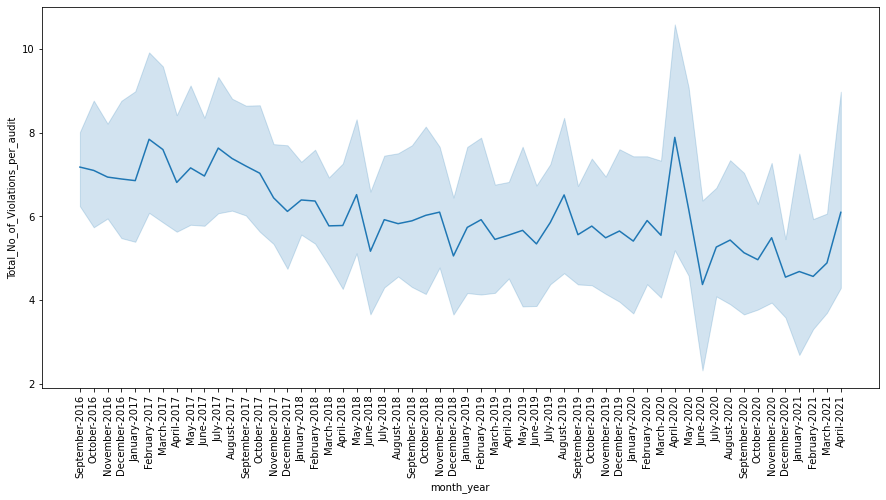

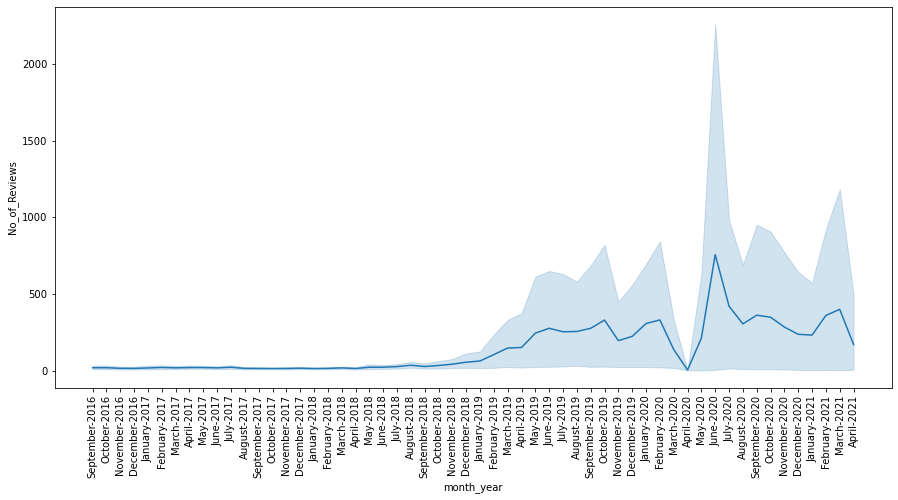

In [10]:
plt.figure(figsize=(15,7))
ax = sns.lineplot(y='Total_No_of_Violations_per_audit', x='month_year', data=df_merged_b)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(y='No_of_Reviews', x='month_year', data=df_merged_b)
plt.xticks(rotation=90)
plt.show()

Finding:
* In terms of volume of data available, there seems to very less no of reviews present > 100 for the time period September 2016 to December 2018 <br>
* <b>Thus the time period we use for analysis is 2019, 2020, 2021<b/> <br>

In [12]:
df_merged_b['Year'] = df_merged_b['month_year'].str[-4:]
df_merged_b['Year'] = df_merged_b['Year'].astype(int)

In [13]:
df_merged_b = df_merged_b[(df_merged_b['Year']==2019) | (df_merged_b['Year']==2020) | (df_merged_b['Year']==2021) ]

After slicing the data for 2019, 2020 & 2021 we retain 18 out of 20 original brands present in ecosure violations data

In [17]:
print("Total No of brands retained :", df_merged_b.Brand.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", df_merged_b.Brand.unique())

Total No of brands retained : 18

 

Name's of the brands used for analysis: ["O'Charley's, Inc." 'On the Border' 'Noodles & Co.' 'Margaritaville'
 'IHOP' 'Benihana National Corp' 'Four Corners Tavern Group' 'Cafe Zupas'
 'Panera' "Friendly's" 'True Food Kitchen' 'Ruby Tuesday Inc.'
 'Twin Peaks' "Applebee's" 'Buffalo Wild Wings' 'Modern Market'
 'Texas Roadhouse' 'Wood Ranch']


# Approach 1: Overall Brand Analysis

## Descriptive Analysis 

Key Message-
* Brands with <b>Lower number of violations</b> have <b>Positive sentiment scores</b>

### Sentiment & Violations/Audit Distribution acrosss brands 1/3

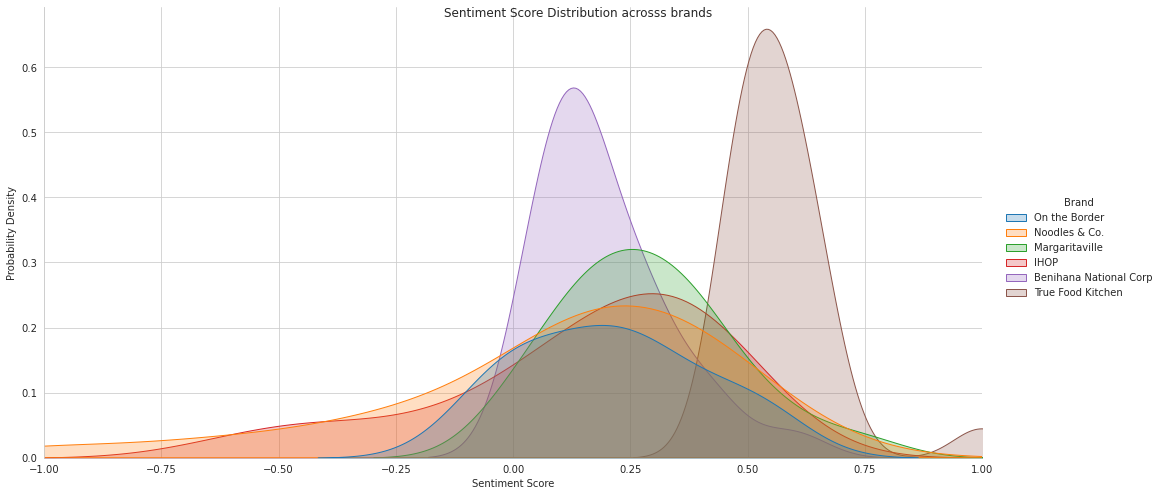

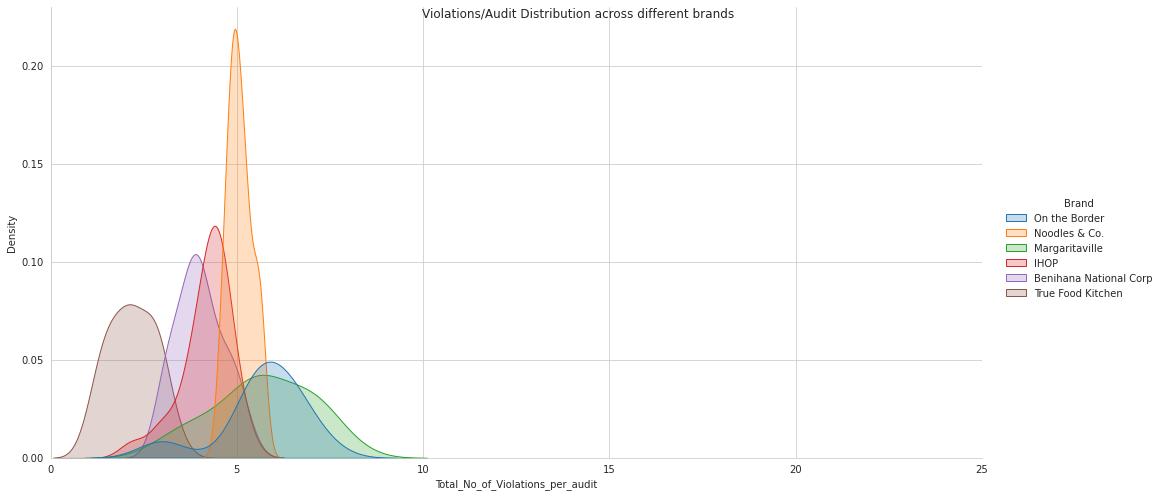

In [14]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged_b[df_merged_b.Brand.isin(['True Food Kitchen', 'Benihana National Corp', 'IHOP', 'Margaritaville', 'Noodles & Co.', 'On the Border'])],
                                                         x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged_b[df_merged_b.Brand.isin(['True Food Kitchen', 'Benihana National Corp', 'IHOP', 'Margaritaville', 'Noodles & Co.', 'On the Border'])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,25))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

In following distribution plots for sentiment score and violation/audit, across 6 brands <b>(On the Border, Noodles & Co, Margaritaville, IHOP, Benihana National Corp, True Food Kitchen) <b> <br>
- For most of the brands Sentiment Scores are on the positive side of the scale and hence lower no of violations less than 10 are observed <br>

### Sentiment & Violations/Audit Distribution acrosss brands 2/3

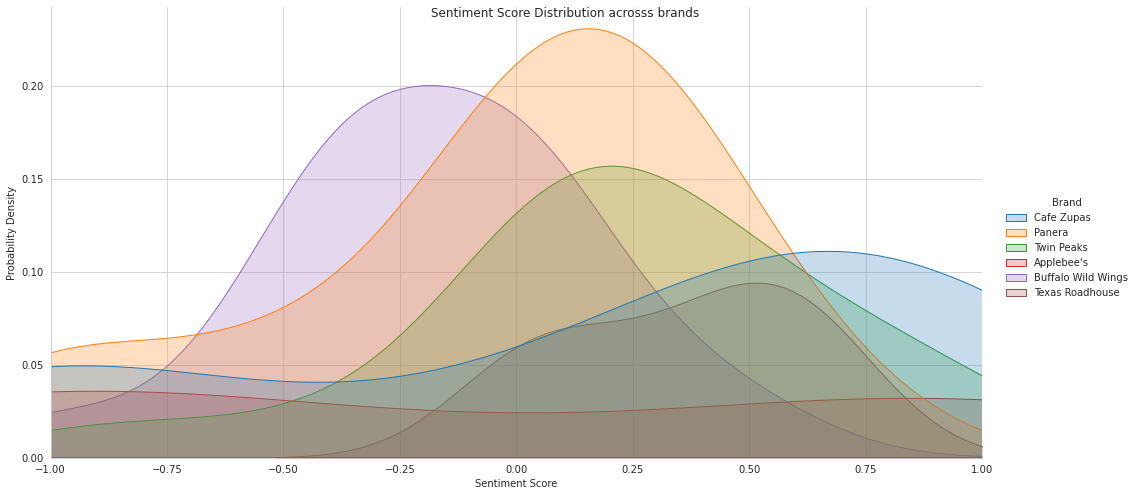

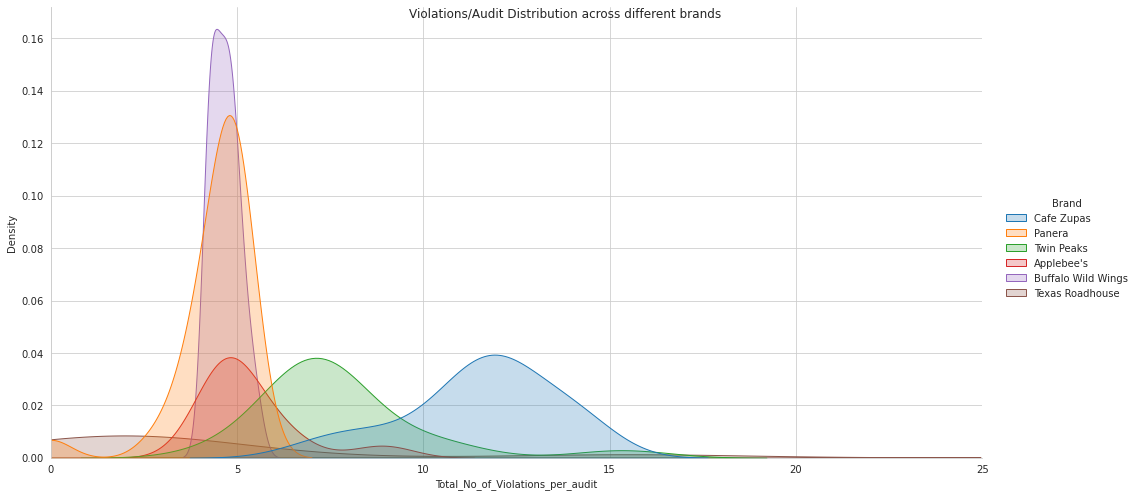

In [20]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged_b[df_merged_b.Brand.isin(['Panera', 'Twin Peaks', 'Buffalo Wild Wings', 'Cafe Zupas', 'Texas Roadhouse', "Applebee's"])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged_b[df_merged_b.Brand.isin(['Panera', 'Twin Peaks', 'Buffalo Wild Wings', 'Cafe Zupas', 'Texas Roadhouse', "Applebee's"])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,25))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

Findings-
* For <b>Cafe Zupas</b>, sentiment score distribution is dense towards negative end and hence they have most number of violations but with a small peak in 5 to 15 range <br>
* For the other brands as well we see there a more dense distribution towards negative end of the sentiment scores, hence the high no of violation greater than 10 upto 25 are observed <br>

### Sentiment & Violations/Audit Distribution acrosss brands 3/3

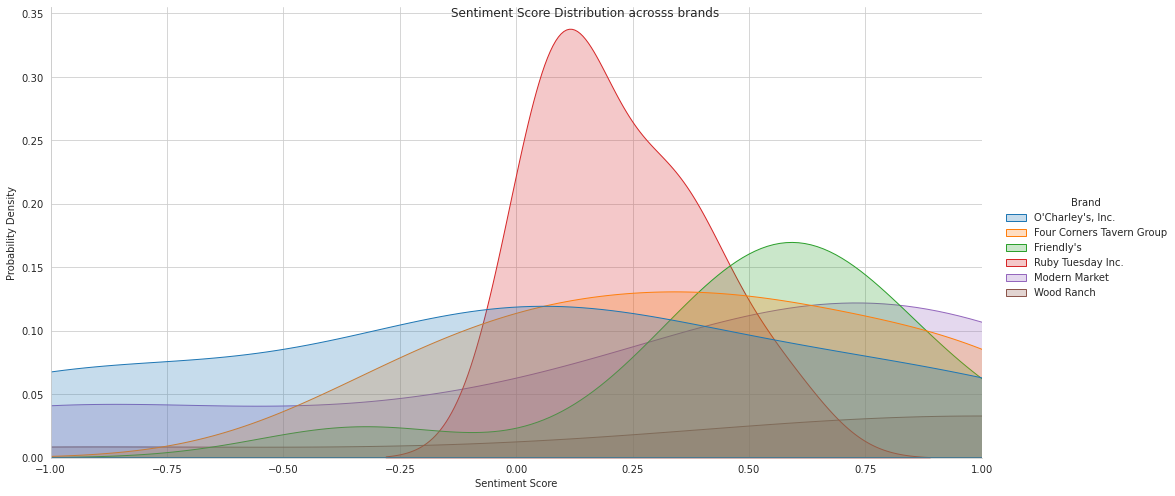

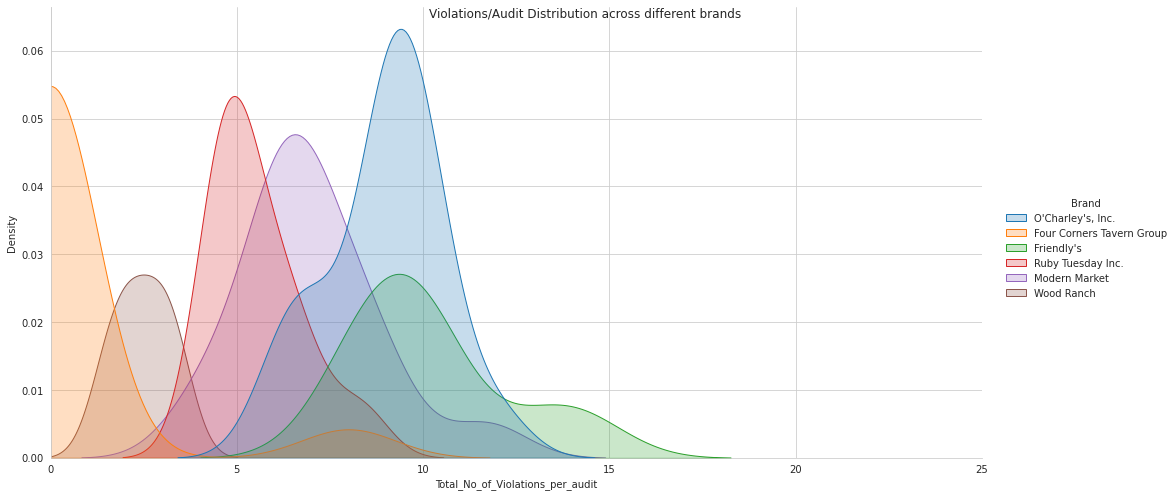

In [19]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged_b[df_merged_b.Brand.isin(["Friendly's", 'Four Corners Tavern Group', 'Ruby Tuesday Inc.', "O'Charley's, Inc.", 'Modern Market', 'Wood Ranch'])],
                 x='Flair_Score', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(-1,1))
ax.set(xlabel = 'Sentiment Score', ylabel = 'Probability Density')
ax.fig.suptitle("Sentiment Score Distribution acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged_b[df_merged_b.Brand.isin(["Friendly's", 'Four Corners Tavern Group', 'Ruby Tuesday Inc.', "O'Charley's, Inc.", 'Modern Market', 'Wood Ranch'])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)

ax.set(xlim=(0,25))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

Findings-
* For <b>O Charleys & Modern Market</b>, sentiment score distribution is dense towards negative end and hence they have most number of violations <br>
* For the brand Friendly's an exception is observed where majority of the sentiment towards the brand in positive but still a peak in the no of violation with 18 violation per audit is observed <br>

### Violations per Audit across different sentiment buckets (Normalized By: No of Reviews)

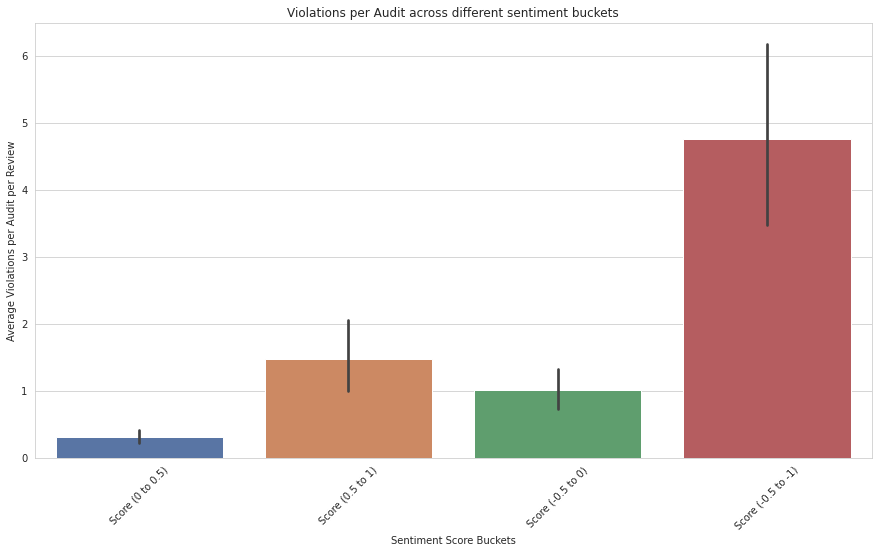

In [21]:
df_dist_senti = df_merged_b.copy()
df_dist_senti['sentiment_bucket'] = df_dist_senti['Flair_Score'].apply(req_intervals)

df_dist_senti['Total_No_of_Violations_per_audit'] = df_dist_senti['Total_No_of_Violations_per_audit']/df_dist_senti['No_of_Reviews']

plt.figure(figsize=(15,8))
ax = sns.barplot(x='sentiment_bucket', y='Total_No_of_Violations_per_audit', data=df_dist_senti, palette = 'deep')
ax.set(xlabel = 'Sentiment Score Buckets', ylabel = 'Average Violations per Audit per Review')
ax.set_title('Violations per Audit across different sentiment buckets')
plt.xticks(rotation=45)
plt.show()

Findings-
* As the average violations per audits per review decreases, the sentiment scores increases (tends towards positive)

### Violations per Audit across different ratings (Normalized By: No of Reviews)

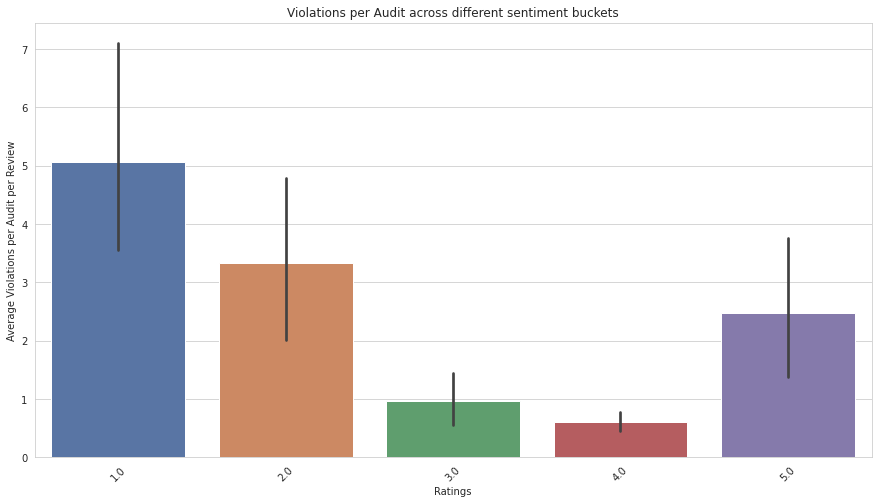

In [22]:
df_dist_senti = df_merged_b.copy()
df_dist_senti['Rating'] = round(df_dist_senti['Rating'],0)

df_dist_senti['Total_No_of_Violations_per_audit'] = df_dist_senti['Total_No_of_Violations_per_audit']/df_dist_senti['No_of_Reviews']

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Rating', y='Total_No_of_Violations_per_audit', data=df_dist_senti, palette = 'deep')
ax.set(xlabel = 'Ratings', ylabel = 'Average Violations per Audit per Review')
ax.set_title('Violations per Audit across different sentiment buckets')
plt.xticks(rotation=45)
plt.show()

Findings-
* As the average violations per audit per review decreases, the review ratings increases (tends towards positive)

In [23]:
df_dist_senti.Rating.value_counts()

4.00    193
3.00     76
2.00     26
5.00     26
1.00      6
Name: Rating, dtype: int64

# Approach 2: Brand Level Analysis

## Correlation Analysis 

Key Message - <br>
* <b>Majority of brands</b> display <b>relationship</b> between our <b>Drivers (i.e. Violations Per Audit, Audit Score)</b> and <b>Measures (i.e. Sentiment Scores, Ratings)</b> for the <b>pillar Delighted Guests</b>

### Total No of Violations per Audit vs Ratings

<b>11 out of 18 brands</b> shows decent <b>negative correlation</b> between total number of violations and review ratings

In [25]:
spearman_corr_brand(df_merged_b[df_merged_b['Rating'].notnull()], 'Total_No_of_Violations_per_audit', 'Rating')

,Brand,Data Points,Correlation Coefficient
0,"O'Charley's, Inc.",18,0.24
1,On the Border,18,0.02
2,Noodles & Co.,28,0.33
3,Margaritaville,24,-0.31
4,IHOP,26,-0.45
5,Benihana National Corp,27,-0.05
6,Four Corners Tavern Group,14,-0.29
7,Cafe Zupas,21,0.21
8,Panera,27,-0.13
9,Friendly's,10,0.09


### Total No of Violations per Audit vs Sentiment Scores

<b>10 out of 18 brands</b> shows decent <b>negative correlation</b> between total number of violations and sentiment scores

In [26]:
spearman_corr_brand(df_merged_b[df_merged_b['Flair_Score'].notnull()], 'Total_No_of_Violations_per_audit', 'Flair_Score')

,Brand,Data Points,Correlation Coefficient
0,"O'Charley's, Inc.",18,0.41
1,On the Border,18,-0.04
2,Noodles & Co.,28,0.24
3,Margaritaville,24,-0.41
4,IHOP,26,-0.44
5,Benihana National Corp,27,-0.05
6,Four Corners Tavern Group,14,-0.25
7,Cafe Zupas,21,0.15
8,Panera,27,0.00
9,Friendly's,10,0.17


### Audit Scores vs Ratings

<b>11 out of 18 brands</b> shows decent <b>positive correlation</b> between audit scores and review ratings

In [28]:
spearman_corr_brand(df_merged_b[df_merged_b['Rating'].notnull()], 'Mean_Audit_Score', 'Rating')

,Brand,Data Points,Correlation Coefficient
0,"O'Charley's, Inc.",18,-0.15
1,On the Border,18,0.12
2,Noodles & Co.,28,0.28
3,Margaritaville,24,0.09
4,IHOP,26,-0.29
5,Benihana National Corp,27,0.26
6,Four Corners Tavern Group,14,-0.29
7,Cafe Zupas,21,-0.20
8,Panera,27,-0.19
9,Friendly's,10,-0.33


### Audit Scores vs Sentiment Scores

<b>8 out of 18 brands</b> shows <b>positive correlation</b> between total number of violations and sentiment scores

In [29]:
spearman_corr_brand(df_merged_b[df_merged_b['Flair_Score'].notnull()], 'Mean_Audit_Score', 'Flair_Score')

,Brand,Data Points,Correlation Coefficient
0,"O'Charley's, Inc.",18,-0.29
1,On the Border,18,-0.19
2,Noodles & Co.,28,0.29
3,Margaritaville,24,0.17
4,IHOP,26,-0.17
5,Benihana National Corp,27,0.26
6,Four Corners Tavern Group,14,-0.25
7,Cafe Zupas,21,-0.13
8,Panera,27,-0.03
9,Friendly's,10,-0.21


# Approach 3: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b>negative correlation between Violations per Audit and Customer Sentiment Measures</b>
* With more <b>Refined Dataset</b>, the <b>correlation</b> becomes <b>more stronger between our Drivers(Mean Audit Score, Violations per Audit) and Measures of Delighted Guests(Sentiment Score, Ratings) </b>
* Same relationship is observed across <b>feature importance and hypothesis testing methods</b> as well

##  Correlation Matrix

### Data Aggregated at Month-Year & Brand Level

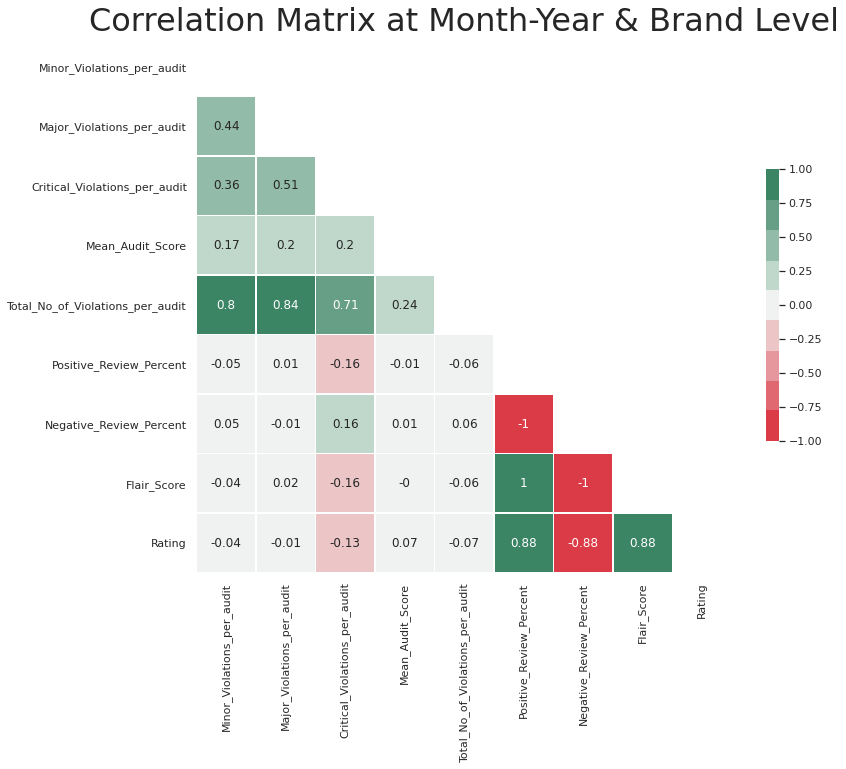

In [30]:
var = ['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit',
       'Mean_Audit_Score', 'Total_No_of_Violations_per_audit', 'Positive_Review_Percent', 
       'Negative_Review_Percent', 'Flair_Score', 'Rating']

correlation_matrix(var, df_merged_b, "Correlation Matrix at Month-Year & Brand Level")

### Data Aggregated at Month-Year & Brand Level (Refined Data)

<b>Criteria for refining dataset:</b>
* Calculated number of audits (normalised by number of stores per brand)
* Calculated median for Audits per Store and Number of reviews
* Filtered for data points having audits per store and number of reviews greater than median values i.e <b>Audit_per_store > 0.247, No_of_Reviews > 18</b>

In [31]:
print(df_merged_b.Audit_per_store.median(), df_merged_b.No_of_Reviews.median())

0.24489795918367346 15.0


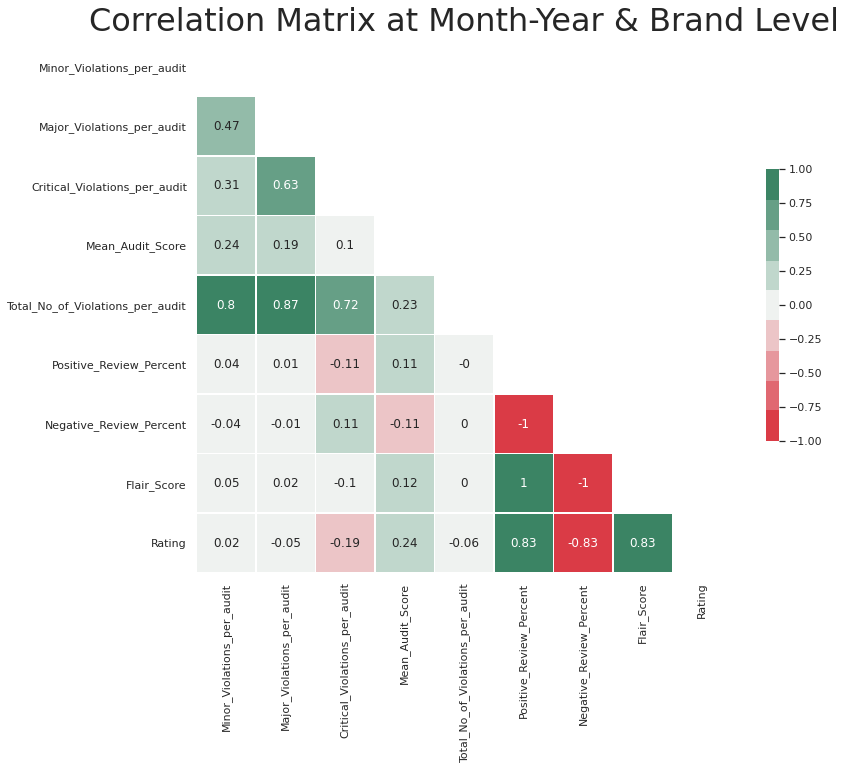

In [32]:
var = ['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit',
       'Mean_Audit_Score', 'Total_No_of_Violations_per_audit', 'Positive_Review_Percent', 
       'Negative_Review_Percent', 'Flair_Score', 'Rating']

correlation_matrix(var, df_merged_b[(df_merged_b.Audit_per_store > df_merged_b.Audit_per_store.median()) & (df_merged_b.No_of_Reviews > df_merged_b.Audit_per_store.median())], "Correlation Matrix at Month-Year & Brand Level")

## Hypothesis Testing (Refined Data)

Results-
* <b>Increase in Violations per Audit, results in decreased Ratings</b>
* <b>Increase in Avg Audit Scores, leads to an increase in Ratings</b>



### Hypothesis 1: Total No of Violations per Audit vs Review Ratings
<br>
<b>Null Hypothesis:</b> Increase in Violations per Audit does not affect ratings
 
<b>Alternate Hypothesis:</b> Increase in Violations per Audit, results in decreased ratings

In [37]:
df_merged_b[df_merged_b['Rating'].notnull() & (df_merged_b.Audit_per_store > df_merged_b.Audit_per_store.median()) & (df_merged_b.No_of_Reviews > df_merged_b.No_of_Reviews.median())].shape

(89, 21)

In [38]:
spearman_corr(df_merged_b[df_merged_b['Rating'].notnull() & (df_merged_b.Audit_per_store > df_merged_b.Audit_per_store.median()) & (df_merged_b.No_of_Reviews > df_merged_b.No_of_Reviews.median())], 'Total_No_of_Violations_per_audit', 'Rating')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.39,0.00,Rejected,Accepted


### Hypothesis 2: Audit Scores vs Review Ratings
<br>
<b>Null Hypothesis:</b> Increase in Avg audit scores does not affect ratings
 
<b>Alternate Hypothesis:</b> Increase in Avg audit scores, results in increase in ratings

In [39]:
spearman_corr(df_merged_b[df_merged_b['Rating'].notnull() & (df_merged_b.Audit_per_store > df_merged_b.Audit_per_store.median()) & (df_merged_b.No_of_Reviews > df_merged_b.No_of_Reviews.median())], 'Mean_Audit_Score', 'Rating')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,0.42,0.00,Rejected,Accepted


### Hypothesis 3: Total No of Violations per Audit vs Sentiment Scores
<br>
<b>Null Hypothesis:</b> Increase in Total No of Violations per Audit does not affect sentiment scores
 
<b>Alternate Hypothesis:</b> Increase in Total No of Violations per Audit, results in decrease in sentiment scores

<b>Spearman Correlation Coefficient</b>

In [40]:
spearman_corr(df_merged_b[df_merged_b['Flair_Score'].notnull() & (df_merged_b.Audit_per_store > df_merged_b.Audit_per_store.median()) & (df_merged_b.No_of_Reviews > df_merged_b.No_of_Reviews.median())], 'Total_No_of_Violations_per_audit', 'Flair_Score')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.24,0.02,Rejected,Accepted


### Hypothesis 4: Audit Scores vs Sentiment Scores
<br>
<b>Null Hypothesis:</b> Increase in Avg audit scores does not affect sentiment scores
 
<b>Alternate Hypothesis:</b> Increase in Avg audit scores, results in increase in sentiment scores

In [41]:
spearman_corr(df_merged_b[df_merged_b['Flair_Score'].notnull() & (df_merged_b.Audit_per_store > df_merged_b.Audit_per_store.median()) & (df_merged_b.No_of_Reviews > df_merged_b.No_of_Reviews.median())], 'Mean_Audit_Score', 'Flair_Score')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,0.32,0.00,Rejected,Accepted


In [42]:
# import semopy
# mod = """Rating ~ Mean_Audit_Score + Total_No_of_Violations_per_audit + No_of_Audits + Flair_Score + Critical_Violations_per_audit +  Minor_Violations_per_audit + Major_Violations_per_audit 
#          Flair_Score ~ Mean_Audit_Score + Total_No_of_Violations_per_audit + No_of_Audits + Critical_Violations_per_audit +  Minor_Violations_per_audit + Major_Violations_per_audit
#       """
# model = semopy.Model(mod)
# model.fit(df_merged_b)
# g = semopy.semplot(model, "pd.png")
# ins = model.inspect()